<a href="https://colab.research.google.com/github/dilul/project-sentiment-analysis/blob/main/Research_Fake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import Libraries

In [18]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hg6_t6jp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hg6_t6jp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [19]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


import clip
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import T5Tokenizer, T5EncoderModel, ViTFeatureExtractor, ViTModel
from transformers import BertTokenizer, BertConfig, BertModel, get_linear_schedule_with_warmup
from transformers import AutoImageProcessor, ResNetModel

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print("tf devices: ", tf.config.list_physical_devices())

tf devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1523730626733623036
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21991653376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11419058452167184122
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


**Load Text and Image Data**

In [21]:
base_dir='/content/gdrive/My Drive/Colab Notebooks/research data/Nalinika'

In [22]:
# Simple Way to Read TSV Files in Python using pandas
img_txt_data_df = pd.read_csv(base_dir+'/multimodal_train.tsv', sep='\t')
# printing data
img_txt_data_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [ ]:
img_txt_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564000 entries, 0 to 563999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                535290 non-null  object 
 1   clean_title           564000 non-null  object 
 2   created_utc           564000 non-null  float64
 3   domain                396143 non-null  object 
 4   hasImage              564000 non-null  bool   
 5   id                    564000 non-null  object 
 6   image_url             562466 non-null  object 
 7   linked_submission_id  167857 non-null  object 
 8   num_comments          396143 non-null  float64
 9   score                 564000 non-null  int64  
 10  subreddit             564000 non-null  object 
 11  title                 564000 non-null  object 
 12  upvote_ratio          396143 non-null  float64
 13  2_way_label           564000 non-null  int64  
 14  3_way_label           564000 non-null  int64  
 15  

In [ ]:
img_txt_data_df.shape

(564000, 16)

In [ ]:
import os
import csv

#These methods create the image mapping
def get_files_in_directory(directory):
    """Get a list of files in the given directory."""
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            files.append((root, filename))
    return files

def write_files_to_csv(files, csv_filename):
    """Write the list of files to a CSV file."""
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['File Location', 'File Name'])  # Write header
        for file_location, file_name in files:
            writer.writerow([file_location, file_name])

if __name__ == "__main__":
    directory = "/content/gdrive/My Drive/Nalinika/train_images2/"
    csv_filename = 'imageMapping.csv'

    files = get_files_in_directory(directory)
    write_files_to_csv(files, csv_filename)

    print(f"File names and locations have been written to {csv_filename}.")


File names and locations have been written to imageMapping.csv.


In [23]:
#Load the image paths file
image_paths_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/research data/imageMapping.csv')
image_paths_df['File Name'] = image_paths_df['File Name'].str.replace('.jpg',"", regex=False)
image_paths_df.rename(columns={"File Location": "Image_Path", "File Name": "id"}, inplace=True)
image_paths_df

,Image_Path,id
0,/content/gdrive/My Drive/Colab Notebooks/resea...,2pn3hb
1,/content/gdrive/My Drive/Colab Notebooks/resea...,2pyj4h
2,/content/gdrive/My Drive/Colab Notebooks/resea...,2pn3pf
3,/content/gdrive/My Drive/Colab Notebooks/resea...,2t4noh
4,/content/gdrive/My Drive/Colab Notebooks/resea...,2ttn6m
...,...,...
167680,/content/gdrive/My Drive/Colab Notebooks/resea...,cqjbxz
167681,/content/gdrive/My Drive/Colab Notebooks/resea...,cqcvrt
167682,/content/gdrive/My Drive/Colab Notebooks/resea...,crcswm
167683,/content/gdrive/My Drive/Colab Notebooks/resea...,creyfhy


In [24]:
display(image_paths_df.drop_duplicates())

,Image_Path,id
0,/content/gdrive/My Drive/Colab Notebooks/resea...,2pn3hb
1,/content/gdrive/My Drive/Colab Notebooks/resea...,2pyj4h
2,/content/gdrive/My Drive/Colab Notebooks/resea...,2pn3pf
3,/content/gdrive/My Drive/Colab Notebooks/resea...,2t4noh
4,/content/gdrive/My Drive/Colab Notebooks/resea...,2ttn6m
...,...,...
167680,/content/gdrive/My Drive/Colab Notebooks/resea...,cqjbxz
167681,/content/gdrive/My Drive/Colab Notebooks/resea...,cqcvrt
167682,/content/gdrive/My Drive/Colab Notebooks/resea...,crcswm
167683,/content/gdrive/My Drive/Colab Notebooks/resea...,creyfhy


In [25]:
img_txt_data_df.drop_duplicates(subset="id",
                     keep=False, inplace=True)

In [26]:
# Merge the datasets on a common identifier ('id')
merged_text_img_data = pd.merge(img_txt_data_df, image_paths_df,on="id")
merged_text_img_data.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,Image_Path
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,/content/gdrive/My Drive/Colab Notebooks/resea...
1,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,/content/gdrive/My Drive/Colab Notebooks/resea...
2,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,/content/gdrive/My Drive/Colab Notebooks/resea...
3,happenpupe,major thermos,1.495660e+09,i.redd.it,True,6d50rl,https://preview.redd.it/l9gvkkf3jizy.jpg?width...,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2,/content/gdrive/My Drive/Colab Notebooks/resea...
4,all-top-today_SS,cutest baby cow ive seen in my head all day an...,1.509141e+09,i.redd.it,True,796d3z,https://preview.redd.it/mbj3et90gbuz.jpg?width...,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3,/content/gdrive/My Drive/Colab Notebooks/resea...


In [ ]:
merged_text_img_data['Image_Path'][2]

'/content/gdrive/My Drive/Colab Notebooks/research data/Nalinika/train_images2/set 30'

# Data Preprocessing and EDA

In [27]:
merged_text_img_data.drop(['author', 'created_utc','image_url'], axis=1, inplace=True)
merged_text_img_data.head(5)

,clean_title,domain,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,Image_Path
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,awxhir,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,/content/gdrive/My Drive/Colab Notebooks/resea...
1,puppy taking in the view,i.imgur.com,True,4xypkv,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,/content/gdrive/My Drive/Colab Notebooks/resea...
2,i found a face in my sheet music too,i.redd.it,True,8gnet9,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,/content/gdrive/My Drive/Colab Notebooks/resea...
3,major thermos,i.redd.it,True,6d50rl,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2,/content/gdrive/My Drive/Colab Notebooks/resea...
4,cutest baby cow ive seen in my head all day an...,i.redd.it,True,796d3z,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3,/content/gdrive/My Drive/Colab Notebooks/resea...


In [28]:
#Get the target names in the dataset
class_names = merged_text_img_data['2_way_label'].unique()
print(class_names)

[1 0]


In [29]:
target_text_img = merged_text_img_data['2_way_label'].value_counts()
print(target_text_img)

2_way_label
0    74177
1    48038
Name: count, dtype: int64


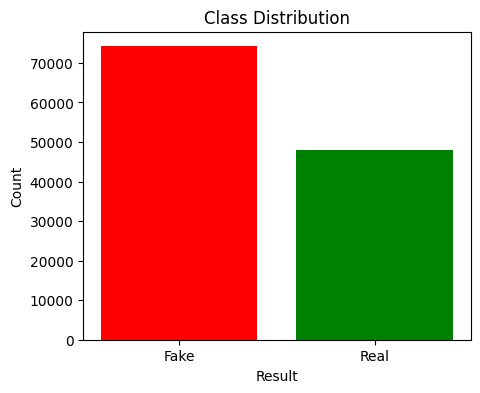

In [30]:
# Count the number of instances in each class
class_counts = merged_text_img_data['2_way_label'].value_counts()

# Plot the class distribution
beingsaved = plt.figure(figsize=(5, 4))
colors = ['red', 'green']
plt.bar(['Fake', 'Real'], class_counts.values, color=colors)
plt.xlabel('Result')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [31]:
merged_text_img_data.isna().sum()

,0
clean_title,0
domain,36460
hasImage,0
id,0
linked_submission_id,85755
num_comments,36460
score,0
subreddit,0
title,0
upvote_ratio,36460


In [ ]:
!pip install transformers

In [ ]:
pip uninstall -y transformers

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2


In [32]:
sub_text_img = merged_text_img_data.head(5000)
sub_text_img

,clean_title,domain,hasImage,id,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,Image_Path
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,awxhir,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,/content/gdrive/My Drive/Colab Notebooks/resea...
1,puppy taking in the view,i.imgur.com,True,4xypkv,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,/content/gdrive/My Drive/Colab Notebooks/resea...
2,i found a face in my sheet music too,i.redd.it,True,8gnet9,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,/content/gdrive/My Drive/Colab Notebooks/resea...
3,major thermos,i.redd.it,True,6d50rl,NaN,0.0,2,pareidolia,major thermos,0.67,0,2,2,/content/gdrive/My Drive/Colab Notebooks/resea...
4,cutest baby cow ive seen in my head all day an...,i.redd.it,True,796d3z,NaN,21.0,141,subredditsimulator,Cutest baby cow I've seen in my head all day a...,0.99,0,2,3,/content/gdrive/My Drive/Colab Notebooks/resea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,single womans cat dreading another friday nigh...,waterfordwhispersnews.com,True,2dpt9q,NaN,0.0,2,satire,Single Woman's Cat Dreading Another Friday Nig...,0.67,0,2,1,/content/gdrive/My Drive/Colab Notebooks/resea...
4996,lets not forget this one,NaN,True,dbt3oe6,5l3gy9,NaN,10,psbattle_artwork,Let's not forget this one,NaN,0,2,4,/content/gdrive/My Drive/Colab Notebooks/resea...
4997,women we cant win without them usa,i.redd.it,True,5qxw3m,NaN,2.0,19,propagandaposters,"""Women ! We cant win without them !"" USA, 1940...",1.00,0,1,5,/content/gdrive/My Drive/Colab Notebooks/resea...
4998,other discussions,NaN,True,cke3vx1,2fz4qt,NaN,1,psbattle_artwork,^Other ^Discussions,NaN,0,2,4,/content/gdrive/My Drive/Colab Notebooks/resea...


In [33]:
sub_text_img.loc[:, 'Image_Path'] = sub_text_img['Image_Path'] + os.sep + sub_text_img['id'] + ".jpg"
sub_text_img['Image_Path'][1]

'/content/gdrive/My Drive/Colab Notebooks/research data/Nalinika/train_images2/set 12/4xypkv.jpg'

In [34]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sub_text_img, test_size=0.20)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (4000, 14)
test shape:  (1000, 14)


In [35]:
import gc

del sub_text_img
del merged_text_img_data
del image_paths_df
del img_txt_data_df
gc.collect()

141

# BERT + ResNet 50

In [51]:
from transformers import AutoTokenizer, AutoImageProcessor, ResNetModel, BertModel

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

In [53]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, tokenizer,image_processor):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.tokenizer = tokenizer
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')

        image = self.image_processor(image)
        text = self.tokenizer(self.texts[idx], return_tensors="pt", padding=True, truncation=True)
        label = self.labels[idx]
        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, image, label

In [54]:
class BertResNetCombinedModel(nn.Module):

    def __init__(self):
        super(BertResNetCombinedModel, self).__init__()
        self.fc1 = nn.Linear(817, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, text_input, image_input):
        with torch.no_grad():

            bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased",device_map='auto')
            bert_output = bert_model(**text_input)

            resnet_model = ResNetModel.from_pretrained("microsoft/resnet-50",device_map='auto')
            image_output = resnet_model(image_input)

        # print(image_output.last_hidden_state[:, 0, :].reshape(8,-1).shape)
        combined_features = torch.cat((bert_output.last_hidden_state[:, 0, :],image_output.last_hidden_state[:, 0, :].reshape(image_output.last_hidden_state[:, 0, :].size(0),-1)), dim=1)
        # torch.flatten(image_output, start_dim=1
        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [55]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_input, image_input, labels = zip(*batch)

    # Process inputs
    text_input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_input], batch_first=True, padding_value=tokenizer.pad_token_id)
    text_attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_input], batch_first=True, padding_value=0)
    # image_pixel_values = torch.stack([x['pixel_values'].unsqueeze(0) for x in image_input])

    text_batch = {
        'input_ids': text_input_ids,
        'attention_mask': text_attention_mask
    }

    image_batch = torch.stack(list(image_input))
    #  {
    #     'pixel_values': image_pixel_values
    # }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


### Train and Evaluate

In [56]:
from torchvision import transforms

In [57]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=1):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for text_inputs, image_inputs, labels in dataloader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = image_inputs.to(device)
            labels = labels.to(device).float()

            outputs = bert_Model(text_inputs,image_inputs).to(device)
            loss = criterion(outputs.squeeze(1), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        print(f"learning_rate: {lr}, batch_size: {batch_size}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return train_losses

In [58]:
def evaluate_model(model, dataloader, criterion, device,accuracy = 0):
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        running_loss = 0.0
        for text_inputs, image_inputs, labels in dataloader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = image_inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(text_inputs, image_inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(dataloader)
        val_losses.append(val_loss)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    classification = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])
    return val_losses, accuracy, classification

In [59]:
param_grid = {
    'learning_rate': [ 1e-3, 1e-4, 1e-5],
    'batch_size': [8,16]
}

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, tokenizer,image_transform)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, tokenizer,image_transform)

best_accuracy = 0
best_params = None
best_classification_report = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    bert_Model = BertResNetCombinedModel().to(device)

    if torch.cuda.is_available():
      bert_Model.cuda()

    loss_fn = nn.BCELoss()
    optimizer =  torch.optim.Adam(bert_Model.parameters(), lr=lr)

   # Training loop
    train_losses = train_model(bert_Model, train_loader, loss_fn, optimizer, device, num_epochs=5)

    # Validation
    val_losses, accuracy,classification = evaluate_model(bert_Model, val_loader, loss_fn, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': loss_fn}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

learning_rate: 0.001, batch_size: 8
Epoch [1/5], Loss: 0.4300
learning_rate: 0.001, batch_size: 8
Epoch [2/5], Loss: 0.3380
learning_rate: 0.001, batch_size: 8
Epoch [3/5], Loss: 0.2927
learning_rate: 0.001, batch_size: 8
Epoch [4/5], Loss: 0.2666
learning_rate: 0.001, batch_size: 8
Epoch [5/5], Loss: 0.2272
Validation Accuracy: 82.90%
learning_rate: 0.001, batch_size: 16
Epoch [1/5], Loss: 0.4293
learning_rate: 0.001, batch_size: 16
Epoch [2/5], Loss: 0.3298
learning_rate: 0.001, batch_size: 16
Epoch [3/5], Loss: 0.3000
learning_rate: 0.001, batch_size: 16
Epoch [4/5], Loss: 0.2568
learning_rate: 0.001, batch_size: 16
Epoch [5/5], Loss: 0.2332
Validation Accuracy: 85.10%
learning_rate: 0.0001, batch_size: 8
Epoch [1/5], Loss: 0.4788
learning_rate: 0.0001, batch_size: 8
Epoch [2/5], Loss: 0.3499
learning_rate: 0.0001, batch_size: 8
Epoch [3/5], Loss: 0.3142
learning_rate: 0.0001, batch_size: 8
Epoch [4/5], Loss: 0.2856
learning_rate: 0.0001, batch_size: 8
Epoch [5/5], Loss: 0.2520
Vali

# BERT + ViT

In [ ]:
class multimodal_attention(nn.Module):
    """
    dot-product attention mechanism
    """
    def __init__(self, attention_dropout=0.5):
        super(multimodal_attention, self).__init__()
        self.dropout = nn.Dropout(attention_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, scale=None, attn_mask=None):

        attention = torch.matmul(q, k.transpose(-2, -1))
        #print('attention.shape:{}'.format(attention.shape))
        if scale:
            attention = attention * scale


        # attention = attention.masked_fill_(attn_mask, -np.inf)
        attention = self.softmax(attention)
        #print('attention.shftmax:{}'.format(attention))
        attention = self.dropout(attention)
        attention = torch.matmul(attention, v)
        #print('attn_final.shape:{}'.format(attention.shape))

        return attention


class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim=256, num_heads=8, dropout=0.5):
        super(MultiHeadAttention, self).__init__()

        self.model_dim = model_dim
        self.dim_per_head = model_dim // num_heads
        self.num_heads = num_heads
        self.linear_k = nn.Linear(1, self.dim_per_head * num_heads, bias=False)
        self.linear_v = nn.Linear(1, self.dim_per_head * num_heads, bias=False)
        self.linear_q = nn.Linear(1, self.dim_per_head * num_heads, bias=False)

        self.dot_product_attention = multimodal_attention(dropout)
        self.linear_final = nn.Linear(model_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, query, key, value, attn_mask=None):
        residual = query
        query = query.unsqueeze(-1)
        key = key.unsqueeze(-1)
        value = value.unsqueeze(-1)
        #print("query.shape:{}".format(query.shape))

        dim_per_head = self.dim_per_head
        num_heads = self.num_heads
        #batch_size = key.size(0)

        # linear projection
        key = self.linear_k(key)
        value = self.linear_v(value)
        query = self.linear_q(query)
        #print('key.shape:{}'.format(key.shape))

        # split by heads
        key = key.view(-1, num_heads, self.model_dim, dim_per_head)
        value = value.view(-1, num_heads, self.model_dim, dim_per_head)
        query = query.view(-1, num_heads, self.model_dim, dim_per_head)

        # scaled dot product attention
        scale = (key.size(-1) // num_heads)**-0.5
        attention = self.dot_product_attention(query, key, value,
                                               scale, attn_mask)

        attention = attention.view(-1, self.model_dim, dim_per_head * num_heads)
        #print('attention_con_shape:{}'.format(attention.shape))

        # final linear projection
        output = self.linear_final(attention).squeeze(-1)
        #print('output.shape:{}'.format(output.shape))
        # dropout
        output = self.dropout(output)
        # add residual and norm layer
        output = self.layer_norm(residual + output)

        return output


class PositionalWiseFeedForward(nn.Module):
    """
    Fully-connected network
    """
    def __init__(self, model_dim=256, ffn_dim=2048, dropout=0.5):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Linear(model_dim, ffn_dim)
        self.w2 = nn.Linear(ffn_dim, model_dim)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        residual = x

        x = self.w2(F.relu(self.w1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)
        output = x
        return output


class multimodal_fusion_layer(nn.Module):
    """
    A layer of fusing features
    """
    def __init__(self, model_dim=256, num_heads=8, ffn_dim=2048, dropout=0.5):
        super(multimodal_fusion_layer, self).__init__()
        self.attention_1 = MultiHeadAttention(model_dim, num_heads, dropout)
        self.attention_2 = MultiHeadAttention(model_dim, num_heads, dropout)

        self.feed_forward_1 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        self.feed_forward_2 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

        self.fusion_linear = nn.Linear(model_dim*2, model_dim)

    def forward(self, image_output, text_output, attn_mask=None):

        output_1 = self.attention_1(image_output, text_output, text_output,
                                 attn_mask)

        output_2 = self.attention_2(text_output, image_output, image_output,
                                 attn_mask)


        #print('attention out_shape:{}'.format(output.shape))
        output_1 = self.feed_forward_1(output_1)
        output_2 = self.feed_forward_2(output_2)

        output = torch.cat([output_1, output_2], dim=1)
        output = self.fusion_linear(output)

        return output

In [ ]:
class NetShareFusion(nn.Module):
    def __init__(self,model_dim,drop_and_BN, img_size=250,num_labels=2,num_layers=1,num_heads=8,ffn_dim=2048,dropout=0.5):

        super(NetShareFusion, self).__init__()

        self.CASED = 'google-bert/bert-base-uncased'
        self.model_dim = model_dim
        # self.pthfile = pthfile
        self.drop_and_BN = drop_and_BN

        #text
        self.config = BertConfig.from_pretrained(self.CASED)

        self.bert = BertModel.from_pretrained(self.CASED)
        self.linear_text = nn.Linear(768, model_dim)
        self.bn_text = nn.BatchNorm1d(model_dim)

        self.dropout = nn.Dropout(dropout)

        #image
        self.vgg = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # ResNetModel.from_pretrained("microsoft/resnet-50")
        #ViTModel.from_pretrained('google/vit-base-patch16-224')

        self.linear_image = nn.Linear(768, model_dim)
        self.bn_vgg = nn.BatchNorm1d(model_dim)

        #dct_image
        # self.dct_img = DctCNN(model_dim,
        #                       dropout,
        #                       kernel_sizes,
        #                       num_channels,
        #                       in_channel=128,
        #                       branch1_channels=[64],
        #                       branch2_channels=[48, 64],
        #                       branch3_channels=[64, 96, 96],
        #                       branch4_channels=[32],
        #                       out_channels=64)
        # self.linear_dct = nn.Linear(4096, model_dim)
        # self.bn_dct = nn.BatchNorm1d(model_dim)

        #multimodal fusion
        self.fusion_layers = nn.ModuleList([
            multimodal_fusion_layer(model_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])

        #classifier
        self.linear1 = nn.Linear(model_dim, 35)
        self.bn_1 = nn.BatchNorm1d(35)
        self.linear2 = nn.Linear(35, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def drop_BN_layer(self, x, part='dct'):
        if part == 'dct':
            bn = self.bn_dct
        elif part == 'vgg':
            bn = self.bn_vgg
        elif part == 'bert':
            bn = self.bn_text

        if self.drop_and_BN == 'drop-BN':
            x = self.dropout(x)
            x = bn(x)
        elif self.drop_and_BN == 'BN-drop':
            x = bn(x)
            x = self.dropout(x)
        elif self.drop_and_BN == 'drop-only':
            x = self.dropout(x)
        elif self.drop_and_BN == 'BN-only':
            x = bn(x)
        elif self.drop_and_BN == 'none':
            pass

        return x

    def forward(self, text_input, image_input):

        #textual feature
        bert_output = self.bert(**text_input)
        text_output = bert_output[1]  #the representation of the whole sentence

        #print('bert_output:{}, shape:{}'.format(text_output, text_output.shape))
        # print(bert_output.last_hidden_state[:, 0, :].shape)

        text_output = F.relu(self.linear_text(bert_output.last_hidden_state[:, 0, :]))
        text_output = self.drop_BN_layer(text_output, part='bert')
#         print('text_output:{}'text_output.shape)

        #visual feature
        output = self.vgg(**image_input)
        # print(output.last_hidden_state[:, 0, :].shape)

        output = F.relu(self.linear_image(output.last_hidden_state[:, 0, :]))
        output = self.drop_BN_layer(output, part='vgg')

        # #dct_feature
        # dct_out = self.dct_img(dct_img)
        # dct_out = F.relu(self.linear_dct(dct_out))
        # dct_out = self.drop_BN_layer(dct_out, part='dct')


        # for fusion_layer in self.fusion_layers:
        #     output = fusion_layer(output, dct_out, attn_mask)

        for fusion_layer in self.fusion_layers:
            output = fusion_layer(output, text_output, text_input['attention_mask'])
            #print('fusion output_shape:{}'.format(output.shape))

        output = F.relu(self.linear1(output))
        output = self.dropout(output)
        #output = self.bn_1(output)
        output = self.linear2(output)
        #print('output_size:{}'.format(output.shape))
        y_pred_prob = self.softmax(output)

        return output, y_pred_prob


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_paths, labels, text_tokenizer, image_processor):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Process text
        text = self.texts[idx]
        text_inputs = self.text_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Process image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.image_processor(images=image, return_tensors="pt")

        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return text_inputs, image_inputs, label


In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_inputs, image_inputs, labels = zip(*batch)

    # Process text inputs
    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=0)
    text_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Process image inputs
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in image_inputs])
    image_batch = {
        'pixel_values': pixel_values
    }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


### Train and Evaluation

In [ ]:
def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1)
        labels_flat = labels
        return np.sum(pred_flat == labels_flat) / len(labels)

In [ ]:
param_grid = {
    'learning_rate': [1e-4, 1e-5],
    'batch_size': [8]
}

test_loss_values = []
acc_values, test_acc_values = [], []
test_precision_values = []
test_recall_values = []
test_f1_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# AutoImageProcessor.from_pretrained("microsoft/resnet-50")
#

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = NetShareFusion(768, 'none').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs)

            # loss_input = outputs[0]
            loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    report_label = []
    report_predict = []

    best_test_acc = 0

    for text_inputs, image_inputs, labels in val_loader:
        text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
        image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
        test_label = labels.to(device)

        with torch.no_grad():
            outputs = model(text_inputs,image_inputs)

        test_loss_input = outputs[0]
        test_loss = criterion(test_loss_input, torch.tensor(test_label,dtype=torch.long))

        predict = torch.max(outputs[1].cpu().detach(), 1)[1]

        test_pred_input = torch.sigmoid(outputs[1]).cpu().detach().numpy().tolist()  #output[1]
        test_label = test_label.cpu().detach().numpy().tolist()

        test_acc = flat_accuracy(test_pred_input, test_label)

        test_batch_loss.append(test_loss.detach().item())
        test_batch_acc.append(test_acc)

        for j in range(len(test_label)):
              report_label.append(test_label[j])
              report_predict.append(predict[j])

    test_epoch_loss = sum(test_batch_loss) / len(val_loader)
    test_epoch_acc = sum(test_batch_acc) / len(val_loader)
    report = classification_report(report_label, report_predict, output_dict = True)

    if test_epoch_acc > best_test_acc:
        best_test_acc = test_epoch_acc
        # self.condition_save(epoch_index, test_epoch_acc, report)

    test_loss_values.append(test_epoch_loss)
    test_acc_values.append(test_epoch_acc)
    test_precision_values.append(float(report["macro avg"]["precision"]))
    test_recall_values.append(float(report["macro avg"]["recall"]))
    test_f1_values.append(float(report["macro avg"]["f1-score"]))


best_accuracy = np.max(test_acc_values)
print(f"Accuracy: {best_accuracy}")
# print(f"Best Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-9a0c7b9b6530>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
<ipython-input-22-9a0c7b9b6530>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Accuracy: 0.84


In [ ]:
param_grid = {
    'learning_rate': [1e-4, 1e-5],
    'batch_size': [8]
}

test_loss_values = []
acc_values, test_acc_values = [], []
test_precision_values = []
test_recall_values = []
test_f1_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# AutoImageProcessor.from_pretrained("microsoft/resnet-50")
#

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = NetShareFusion(768, 'none').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs)

            # loss_input = outputs[0]
            loss = criterion(outputs[0],  torch.tensor(labels,dtype=torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    report_label = []
    report_predict = []

    best_test_acc = 0

    for text_inputs, image_inputs, labels in val_loader:
        text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
        image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
        test_label = labels.to(device)

        with torch.no_grad():
            outputs = model(text_inputs,image_inputs)

        test_loss_input = outputs[0]
        test_loss = criterion(test_loss_input, torch.tensor(test_label,dtype=torch.long))

        predict = torch.max(outputs[1].cpu().detach(), 1)[1]

        test_pred_input = torch.sigmoid(outputs[1]).cpu().detach().numpy().tolist()  #output[1]
        test_label = test_label.cpu().detach().numpy().tolist()

        test_acc = flat_accuracy(test_pred_input, test_label)

        test_batch_loss.append(test_loss.detach().item())
        test_batch_acc.append(test_acc)

        for j in range(len(test_label)):
              report_label.append(test_label[j])
              report_predict.append(predict[j])

    test_epoch_loss = sum(test_batch_loss) / len(val_loader)
    test_epoch_acc = sum(test_batch_acc) / len(val_loader)
    report = classification_report(report_label, report_predict, output_dict = True)

    if test_epoch_acc > best_test_acc:
        best_test_acc = test_epoch_acc
        # self.condition_save(epoch_index, test_epoch_acc, report)

    test_loss_values.append(test_epoch_loss)
    test_acc_values.append(test_epoch_acc)
    test_precision_values.append(float(report["macro avg"]["precision"]))
    test_recall_values.append(float(report["macro avg"]["recall"]))
    test_f1_values.append(float(report["macro avg"]["f1-score"]))

    # val_predictions = np.array(val_predictions) > 0.5
    # accuracy = accuracy_score(val_targets, val_predictions)

    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     best_params = {'learning_rate': lr, 'batch_size': batch_size}

best_accuracy = np.max(test_acc_values)
print(f"Accuracy: {best_accuracy}")
print(f"Accuracy: {best_accuracy}")
print(f"Accuracy: {best_accuracy}")
# print(f"Best Params: {best_params}")


# CLIP based Model

## Early Fusion

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = self.preprocess(image).unsqueeze(0).to(device)
        text = clip.tokenize(self.texts[idx])
        label = self.labels[idx]
        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, image, label

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, clip_model):
        super(CombinedModel, self).__init__()
        self.clip_model = clip_model
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, image, text):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [ ]:
texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

dataset = FakeNewsDataset(texts, images, labels, preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
combined_model = CombinedModel(model).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):  # Number of epochs

    for texts, images, labels in dataloader:

        images = images.squeeze(1).to(device)
        texts = texts.squeeze(1).to(device)  # Remove the batch dimension from text inputs
        labels = labels.to(device).float()

        # Forward pass
        outputs = combined_model(images, texts).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6550
Epoch [2/10], Loss: 0.5318
Epoch [3/10], Loss: 0.2847
Epoch [4/10], Loss: 0.2649
Epoch [5/10], Loss: 0.1784
Epoch [6/10], Loss: 0.1567
Epoch [7/10], Loss: 0.1334
Epoch [8/10], Loss: 0.0736
Epoch [9/10], Loss: 0.0813
Epoch [10/10], Loss: 0.0459


In [ ]:
# Evaluate the model
def evaluate(model, dataloader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for texts, images, labels in dataloader:

            images = images.squeeze(1).to(device)
            texts = texts.squeeze(1).to(device)
            labels = labels.to(device).float()
            outputs = model(images, texts).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

texts = test_df['title'].values
images = test_df['Image_Path'].values
labels = test_df['2_way_label'].values

# Assuming you have a test dataloader
dataset = FakeNewsDataset(texts, images, labels, preprocess)
print(test_df.shape)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

evaluate(combined_model, test_dataloader)

(200, 14)
Accuracy: 87.00%


In [ ]:
class ClipBasedModel(nn.Module):
    def __init__(self, clip_model, hidden_dim):
        super(ClipBasedModel, self).__init__()
        self.clip_model = clip_model
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.float()

    def forward(self, image, text):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


### Train and Evaluation

**Hyper-parameter Tunning**

In [ ]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for text_inputs, image_inputs, labels in dataloader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = model(image_inputs,text_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        print(f"learning_rate: {lr}, batch_size: {batch_size}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return train_losses

In [ ]:
def evaluate_model(model, dataloader, criterion, device,accuracy = 0):
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        running_loss = 0.0
        for text_inputs, image_inputs, labels in dataloader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()

            outputs = model(image_inputs,text_inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(dataloader)
        val_losses.append(val_loss)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    classification = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])
    return val_losses, accuracy, classification

In [ ]:
import os
import pandas as pd
from PIL import Image

def image_exists(image_path):
    # Check if file exists
    if not os.path.isfile(image_path):
        return False

    # Check if file is an image
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError) as e:
        return False

newdf = test_df.copy()
# Apply the function to the DataFrame column
newdf['image_exists'] = newdf['Image_Path'].apply(image_exists)

# Filter to get rows where image_exists is False
false_paths = newdf[newdf['image_exists'] == False]

print("Paths where the image does not exist or is not a valid image:")
print(false_paths['Image_Path'].tolist())


Paths where the image does not exist or is not a valid image:
['/content/gdrive/My Drive/Colab Notebooks/research data/Nalinika/train_images2/set 64/cqhowgl.jpg']


In [ ]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [8, 16],
    'hidden_dim': [1024]
}

texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size, hidden_dim in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = ClipBasedModel(model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    if torch.cuda.is_available():
      bert_Model.cuda()

   # Training loop
    train_losses = train_model(clip_Model, train_loader, criterion, optimizer, device, num_epochs=5)

    # Validation
    val_losses, accuracy,classification = evaluate_model(clip_Model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")


learning_rate: 0.001, batch_size: 8
Epoch [1/5], Loss: 0.2959
learning_rate: 0.001, batch_size: 8
Epoch [2/5], Loss: 0.1675
learning_rate: 0.001, batch_size: 8
Epoch [3/5], Loss: 0.0897
learning_rate: 0.001, batch_size: 8
Epoch [4/5], Loss: 0.0381
learning_rate: 0.001, batch_size: 8
Epoch [5/5], Loss: 0.0270
Validation Accuracy: 90.30%
learning_rate: 0.001, batch_size: 16
Epoch [1/5], Loss: 0.3023
learning_rate: 0.001, batch_size: 16
Epoch [2/5], Loss: 0.1621
learning_rate: 0.001, batch_size: 16
Epoch [3/5], Loss: 0.0745
learning_rate: 0.001, batch_size: 16
Epoch [4/5], Loss: 0.0271
learning_rate: 0.001, batch_size: 16
Epoch [5/5], Loss: 0.0141
Validation Accuracy: 90.00%
learning_rate: 0.0001, batch_size: 8
Epoch [1/5], Loss: 0.3490
learning_rate: 0.0001, batch_size: 8
Epoch [2/5], Loss: 0.2061
learning_rate: 0.0001, batch_size: 8
Epoch [3/5], Loss: 0.1458
learning_rate: 0.0001, batch_size: 8
Epoch [4/5], Loss: 0.0857
learning_rate: 0.0001, batch_size: 8
Epoch [5/5], Loss: 0.0379
Vali

## Decision Level Fusion

In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    inputs, labels = zip(*batch)

    # Process inputs
    text_input_ids = pad_sequence([x['input_ids'].squeeze(0) for x in inputs], batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    text_attention_mask = pad_sequence([x['attention_mask'].squeeze(0) for x in inputs], batch_first=True, padding_value=0)
    image_pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in inputs])

    text_batch = {
        'input_ids': text_input_ids,
        'attention_mask': text_attention_mask
    }
    image_batch = {
        'pixel_values': image_pixel_values
    }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


In [ ]:
class MultimodalDecisionLevelFusionModel(nn.Module):
    def __init__(self, clip_model, hidden_dim):
        super(MultimodalDecisionLevelFusionModel, self).__init__()
        self.clip_model = clip_model
        self.fc_text = nn.Linear(clip_model.text_projection.shape[0], hidden_dim)
        self.fc_image = nn.Linear(clip_model.visual.output_dim, hidden_dim)
        self.fc_combined = nn.Linear(hidden_dim * 2, 256)
        self.fc_final = nn.Linear(256, 1)


    def forward(self, image, text):
        with torch.no_grad():
            text_embeddings = self.clip_model.encode_image(image)
            image_embeddings = self.clip_model.encode_text(text)

        text_features = torch.relu(self.fc_text(text_embeddings.float()))
        image_features = torch.relu(self.fc_image(image_embeddings.float()))

        combined_features = torch.cat((text_features, image_features), dim=1)

        x = torch.relu(self.fc_combined(combined_features))
        x = torch.sigmoid(self.fc_final(x))

        return x


### Train and Evaluation

In [ ]:
param_grid = {
    'learning_rate': [ 1e-3, 1e-4, 1e-5],
    'batch_size': [8, 16],
    'hidden_dim': [512]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size, hidden_dim in product(*param_grid.values()):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    late_fusion_clip_Model = MultimodalDecisionLevelFusionModel(model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    if torch.cuda.is_available():
      bert_Model.cuda()

   # Training loop
    train_losses = train_model(late_fusion_clip_Model, train_loader, criterion, optimizer, device, num_epochs=5)

    # Validation
    val_losses, accuracy,classification = evaluate_model(late_fusion_clip_Model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion, 'hidden_dim': hidden_dim}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")


learning_rate: 0.001, batch_size: 8
Epoch [1/5], Loss: 0.6947
learning_rate: 0.001, batch_size: 8
Epoch [2/5], Loss: 0.6947
learning_rate: 0.001, batch_size: 8
Epoch [3/5], Loss: 0.6947
learning_rate: 0.001, batch_size: 8
Epoch [4/5], Loss: 0.6947
learning_rate: 0.001, batch_size: 8
Epoch [5/5], Loss: 0.6947
Validation Accuracy: 44.60%
learning_rate: 0.001, batch_size: 16
Epoch [1/5], Loss: 0.7033
learning_rate: 0.001, batch_size: 16
Epoch [2/5], Loss: 0.7033
learning_rate: 0.001, batch_size: 16
Epoch [3/5], Loss: 0.7033
learning_rate: 0.001, batch_size: 16
Epoch [4/5], Loss: 0.7033
learning_rate: 0.001, batch_size: 16
Epoch [5/5], Loss: 0.7033
Validation Accuracy: 38.90%
learning_rate: 0.0001, batch_size: 8
Epoch [1/5], Loss: 0.7061
learning_rate: 0.0001, batch_size: 8
Epoch [2/5], Loss: 0.7061
learning_rate: 0.0001, batch_size: 8
Epoch [3/5], Loss: 0.7061
learning_rate: 0.0001, batch_size: 8
Epoch [4/5], Loss: 0.7061
learning_rate: 0.0001, batch_size: 8
Epoch [5/5], Loss: 0.7061
Vali

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


learning_rate: 0.0001, batch_size: 16
Epoch [1/5], Loss: 0.6892
learning_rate: 0.0001, batch_size: 16
Epoch [2/5], Loss: 0.6892
learning_rate: 0.0001, batch_size: 16
Epoch [3/5], Loss: 0.6892
learning_rate: 0.0001, batch_size: 16
Epoch [4/5], Loss: 0.6892
learning_rate: 0.0001, batch_size: 16
Epoch [5/5], Loss: 0.6892
Validation Accuracy: 56.80%
learning_rate: 1e-05, batch_size: 8
Epoch [1/5], Loss: 0.6953
learning_rate: 1e-05, batch_size: 8
Epoch [2/5], Loss: 0.6953
learning_rate: 1e-05, batch_size: 8
Epoch [3/5], Loss: 0.6953
learning_rate: 1e-05, batch_size: 8
Epoch [4/5], Loss: 0.6953
learning_rate: 1e-05, batch_size: 8
Epoch [5/5], Loss: 0.6953
Validation Accuracy: 45.40%
learning_rate: 1e-05, batch_size: 16
Epoch [1/5], Loss: 0.6894
learning_rate: 1e-05, batch_size: 16
Epoch [2/5], Loss: 0.6894
learning_rate: 1e-05, batch_size: 16
Epoch [3/5], Loss: 0.6894
learning_rate: 1e-05, batch_size: 16
Epoch [4/5], Loss: 0.6894
learning_rate: 1e-05, batch_size: 16
Epoch [5/5], Loss: 0.6894

In [ ]:
import gc

# del bert_Model
# del clip_Model
# del df
# del newdf
# del tokenizer
gc.collect()

2644

# BLIP +CLIP Model

## Hybrid Fusion

In [ ]:
import clip
from PIL import Image
import torch
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForImageTextRetrieval

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
# blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 24.7MiB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess, image_processor):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])

        preprocessed_image = self.preprocess(image).unsqueeze(0).to(device)
        text = clip.tokenize(self.texts[idx])
        label = self.labels[idx]

        encoding = self.image_processor(images=image, text=self.texts[idx], padding="max_length", return_tensors="pt")
        # remove batch dimension

        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, preprocessed_image, label, encoding

In [ ]:
class ClipAndBlipCombinedModel(nn.Module):
    def __init__(self, clip_model, blip_model):
        super(ClipAndBlipCombinedModel, self).__init__()
        self.clip_model = clip_model
        self.blip_model = blip_model
        self.fc1_clip = nn.Linear(1024, 512)
        self.fc2_clip = nn.Linear(512, 256)
        self.fc1_blip = nn.Linear(1024, 512)
        self.fc2_blip = nn.Linear(512, 256)
        self.fc3_clip = nn.Linear(256, 1)  # Assuming binary classification
        self.float()

    def forward(self, image, text, encodings):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1_clip(combined_features))
        x = torch.relu(self.fc2_clip(x))

        blip_outputs = self.blip_model(**encodings)

        # logits_per_image = blip_outputs.logits_per_image
        # probs = logits_per_image.softmax(dim=1)

        x_combined = torch.cat((x, blip_outputs.last_hidden_state[:, 0, :]), dim=1)

        x  = self.fc1_blip(x_combined)
        x = self.fc2_blip(x)
        x = F.relu(x)

        x = torch.sigmoid(self.fc3_clip(x))

        return x


### Train and Evaluation

In [ ]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for text_inputs, image_inputs, labels,encoding in dataloader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = model(image_inputs,text_inputs, encoding)
            loss = criterion(outputs, labels.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        print(f"learning_rate: {lr}, batch_size: {batch_size}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return train_losses

In [ ]:
def evaluate_model(model, dataloader, criterion, device,accuracy = 0):
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        running_loss = 0.0
        for text_inputs, image_inputs, labels, encoding in dataloader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = model(image_inputs,text_inputs,encoding).squeeze()
            loss = criterion(outputs,  labels)
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(dataloader)
        val_losses.append(val_loss)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    classification = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])
    return val_losses, accuracy, classification

In [ ]:

param_grid = {
    'learning_rate': [1e-3, 1e-4,1e-5],
    'batch_size': [4,8]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess, processor)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess,processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = ClipAndBlipCombinedModel(model,blip_model).to(device)

    if torch.cuda.is_available():
      clip_Model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

   # Training loop
    train_losses = train_model(clip_Model, train_loader, criterion, optimizer, device, num_epochs=5)

    # Validation
    val_losses, accuracy,classification = evaluate_model(clip_Model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")



learning_rate: 0.001, batch_size: 4
Epoch [1/5], Loss: 0.3163
learning_rate: 0.001, batch_size: 4
Epoch [2/5], Loss: 0.2011
learning_rate: 0.001, batch_size: 4
Epoch [3/5], Loss: 0.1161
learning_rate: 0.001, batch_size: 4
Epoch [4/5], Loss: 0.0628
learning_rate: 0.001, batch_size: 4
Epoch [5/5], Loss: 0.0543
Validation Accuracy: 88.00%
learning_rate: 0.001, batch_size: 8
Epoch [1/5], Loss: 0.3029
learning_rate: 0.001, batch_size: 8
Epoch [2/5], Loss: 0.1821
learning_rate: 0.001, batch_size: 8
Epoch [3/5], Loss: 0.1012
learning_rate: 0.001, batch_size: 8
Epoch [4/5], Loss: 0.0550
learning_rate: 0.001, batch_size: 8
Epoch [5/5], Loss: 0.0379
Validation Accuracy: 88.20%
learning_rate: 0.0001, batch_size: 4
Epoch [1/5], Loss: 0.3091
learning_rate: 0.0001, batch_size: 4
Epoch [2/5], Loss: 0.1636
learning_rate: 0.0001, batch_size: 4
Epoch [3/5], Loss: 0.0721
learning_rate: 0.0001, batch_size: 4
Epoch [4/5], Loss: 0.0200
learning_rate: 0.0001, batch_size: 4
Epoch [5/5], Loss: 0.0209
Validatio

In [ ]:

param_grid = {
    'learning_rate': [1e-4],
    'batch_size': [4]
}

texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess, processor)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess,processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = ClipAndBlipCombinedModel(model,blip_model).to(device)

    if torch.cuda.is_available():
      model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, encoding in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = clip_Model(image_inputs,text_inputs,encoding)
            del text_inputs
            del image_inputs
            del encoding

            loss = criterion(outputs, labels.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,encoding in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = clip_Model(image_inputs,text_inputs,encoding).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


Best Accuracy: 0.915
Best Params: {'learning_rate': 0.0001, 'batch_size': 4}


In [ ]:
import gc

# del bert_Model
del clip_Model
del preprocess
# del newdf
# del tokenizer
gc.collect()

14

## Early Fusion

In [ ]:
from transformers import BlipProcessor, BlipForImageTextRetrieval


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/895M [00:00<?, ?B/s]

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess, image_processor):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])

        preprocessed_image = self.preprocess(image).unsqueeze(0).to(device)
        text = clip.tokenize(self.texts[idx])
        label = self.labels[idx]

        encoding = self.image_processor(images=image, text=self.texts[idx], padding="max_length", return_tensors="pt")
        # remove batch dimension

        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, preprocessed_image, label, encoding

In [ ]:
class ClipBasedModel(nn.Module):
    def __init__(self, clip_model):
        super(ClipBasedModel, self).__init__()
        self.clip_model = clip_model
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, image, text):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [ ]:
class BlipCombinedModel(nn.Module):
    def __init__(self, blip_model,clip_model):
        super(BlipCombinedModel,self).__init__()
        self.clip_model = ClipBasedModel(clip_model)
        self.blip_model = blip_model
        self.fc1 = nn.Linear(769 , 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification
        self.float()

    def forward(self, image, text, encodings):
        with torch.no_grad():
            text_img_output = self.clip_model(image, text)
            blip_model_output = self.blip_model(**encodings)
        combined_features = torch.cat((text_img_output, blip_model_output.last_hidden_state[:, 0, :]), dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        # x_combined = torch.cat((x, blip_outputs.last_hidden_state[:, 0, :]), dim=1)

        x = torch.sigmoid(self.fc3(x))

        return x


### Train and Evaluation

In [ ]:

param_grid = {
    'learning_rate': [1e-3,1e-4,1e-5],
    'batch_size': [8]
}


texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess, processor)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess,processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = BlipCombinedModel(blip_model,model).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    train_losses = train_model(clip_Model, train_loader, criterion, optimizer, device, num_epochs=5)

    val_losses, accuracy,classification = evaluate_model(clip_Model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")

learning_rate: 0.001, batch_size: 8
Epoch [1/5], Loss: 0.5077
learning_rate: 0.001, batch_size: 8
Epoch [2/5], Loss: 0.4212
learning_rate: 0.001, batch_size: 8
Epoch [3/5], Loss: 0.3753
learning_rate: 0.001, batch_size: 8
Epoch [4/5], Loss: 0.3093
learning_rate: 0.001, batch_size: 8
Epoch [5/5], Loss: 0.2392
Validation Accuracy: 78.80%
learning_rate: 0.0001, batch_size: 8
Epoch [1/5], Loss: 0.5430
learning_rate: 0.0001, batch_size: 8
Epoch [2/5], Loss: 0.4340
learning_rate: 0.0001, batch_size: 8
Epoch [3/5], Loss: 0.3838
learning_rate: 0.0001, batch_size: 8
Epoch [4/5], Loss: 0.3236
learning_rate: 0.0001, batch_size: 8
Epoch [5/5], Loss: 0.2492
Validation Accuracy: 79.70%
learning_rate: 1e-05, batch_size: 8
Epoch [1/5], Loss: 0.6582
learning_rate: 1e-05, batch_size: 8
Epoch [2/5], Loss: 0.6040
learning_rate: 1e-05, batch_size: 8
Epoch [3/5], Loss: 0.5441
learning_rate: 1e-05, batch_size: 8
Epoch [4/5], Loss: 0.5027
learning_rate: 1e-05, batch_size: 8
Epoch [5/5], Loss: 0.4779
Validatio

In [ ]:
import gc

del blip_model
del clip_Model
del train_loader
del val_loader
del val_dataset
del train_dataset
# del newdf
# del tokenizer
gc.collect()

96

# T5 + ViT Based Model

## Early Fusion (Concat Fusion Method)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_paths, labels, text_tokenizer, image_processor):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Process text
        text = self.texts[idx]
        text_inputs = self.text_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Process image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.image_processor(images=image, return_tensors="pt")

        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return text_inputs, image_inputs, label


In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_inputs, image_inputs, labels = zip(*batch)

    # Process text inputs
    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=0)
    text_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Process image inputs
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in image_inputs])
    image_batch = {
        'pixel_values': pixel_values
    }

    # Process labels
    labels = torch.tensor(labels)

    return text_batch, image_batch, labels


In [ ]:
# Example data
texts = train_df['title'].values
image_paths = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

# Initialize the tokenizers and processors
text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Create dataset and dataloader
dataset = CustomDataset(texts, image_paths, labels, text_tokenizer, image_processor)

# def collate_fn(data):
#     zipped = zip(data)
#     return list(zipped)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings

        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        x = torch.relu(self.fc1(combined_embeddings))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
for epoch in range(5):  # Number of epochs
    model.train()
    for text_inputs, image_inputs, labels in dataloader:
        # Move to device

        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
        labels = labels.to(device)

        # Forward pass
        outputs = model(text_inputs, image_inputs).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.5856
Epoch [2/5], Loss: 0.3786
Epoch [3/5], Loss: 0.1837
Epoch [4/5], Loss: 0.2141
Epoch [5/5], Loss: 0.0054


In [ ]:
# Evaluate the model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for text_inputs, image_inputs, labels in dataloader:
            # Move to device
            text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            # Forward pass
            outputs = model(text_inputs, image_inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Assuming you have a test dataloader
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
# evaluate(model, test_dataloader)
texts = test_df['title'].values
images = test_df['Image_Path'].values
labels = test_df['2_way_label'].values

# Assuming you have a test dataloader
dataset = CustomDataset(texts, images, labels, text_tokenizer, image_processor)

print(test_df.shape)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

evaluate(model, test_dataloader)

(200, 14)
Accuracy: 73.50%


### Train and Evaluation

**Hyper-parameter Tunning**

In [ ]:
class T5ViTCombinedModel(nn.Module):
    def __init__(self):
        super(T5ViTCombinedModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings

        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        x = torch.relu(self.fc1(combined_embeddings))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [ ]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for text_inputs, image_inputs, labels in dataloader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs, image_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        print(f"learning_rate: {lr}, batch_size: {batch_size}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return train_losses

In [ ]:
def evaluate_model(model, dataloader, criterion, device,accuracy = 0):
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        running_loss = 0.0
        for text_inputs, image_inputs, labels in dataloader:
            text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
            labels = labels.to(device)

            outputs = model(text_inputs,image_inputs).squeeze()
            loss = criterion(outputs,  labels)
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(dataloader)
        val_losses.append(val_loss)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    classification = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])
    return val_losses, accuracy, classification

In [ ]:
param_grid = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = T5ViTCombinedModel().to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

    val_losses, accuracy,classification = evaluate_model(model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.01, batch_size: 8
Epoch [1/5], Loss: 0.7382
learning_rate: 0.01, batch_size: 8
Epoch [2/5], Loss: 0.6362
learning_rate: 0.01, batch_size: 8
Epoch [3/5], Loss: 0.6724
learning_rate: 0.01, batch_size: 8
Epoch [4/5], Loss: 0.6727
learning_rate: 0.01, batch_size: 8
Epoch [5/5], Loss: 0.6717
Validation Accuracy: 58.60%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of ViTModel were not initialized from the model che

learning_rate: 0.01, batch_size: 16
Epoch [1/5], Loss: 42.6264
learning_rate: 0.01, batch_size: 16
Epoch [2/5], Loss: 39.5500
learning_rate: 0.01, batch_size: 16
Epoch [3/5], Loss: 39.5500
learning_rate: 0.01, batch_size: 16
Epoch [4/5], Loss: 39.5500
learning_rate: 0.01, batch_size: 16
Epoch [5/5], Loss: 39.5500
Validation Accuracy: 58.60%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of ViTModel were not initialized from the model che

learning_rate: 0.001, batch_size: 8
Epoch [1/5], Loss: 0.4361
learning_rate: 0.001, batch_size: 8
Epoch [2/5], Loss: 0.2772
learning_rate: 0.001, batch_size: 8
Epoch [3/5], Loss: 0.2062
learning_rate: 0.001, batch_size: 8
Epoch [4/5], Loss: 0.1381
learning_rate: 0.001, batch_size: 8
Epoch [5/5], Loss: 0.1029
Validation Accuracy: 84.30%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.001, batch_size: 16
Epoch [1/5], Loss: 0.4666
learning_rate: 0.001, batch_size: 16
Epoch [2/5], Loss: 0.2624
learning_rate: 0.001, batch_size: 16
Epoch [3/5], Loss: 0.1537
learning_rate: 0.001, batch_size: 16
Epoch [4/5], Loss: 0.1073
learning_rate: 0.001, batch_size: 16
Epoch [5/5], Loss: 0.0830
Validation Accuracy: 84.30%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.0001, batch_size: 8
Epoch [1/5], Loss: 0.4689
learning_rate: 0.0001, batch_size: 8
Epoch [2/5], Loss: 0.2330
learning_rate: 0.0001, batch_size: 8
Epoch [3/5], Loss: 0.0995
learning_rate: 0.0001, batch_size: 8
Epoch [4/5], Loss: 0.0720
learning_rate: 0.0001, batch_size: 8
Epoch [5/5], Loss: 0.0560
Validation Accuracy: 87.20%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.0001, batch_size: 16
Epoch [1/5], Loss: 0.5031
learning_rate: 0.0001, batch_size: 16
Epoch [2/5], Loss: 0.2191
learning_rate: 0.0001, batch_size: 16
Epoch [3/5], Loss: 0.0796
learning_rate: 0.0001, batch_size: 16
Epoch [4/5], Loss: 0.0487
learning_rate: 0.0001, batch_size: 16
Epoch [5/5], Loss: 0.0191
Validation Accuracy: 84.40%
Best Accuracy: 0.872
Best Params: {'learning_rate': 0.0001, 'batch_size': 8, 'loss_fn': BCELoss()}
Best Classification Report:               precision    recall  f1-score   support

        Fake       0.88      0.90      0.89       586
        Real       0.85      0.83      0.84       414

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



## Decision Level Fusion

In [ ]:
class LateFusionModel(nn.Module):
    def __init__(self, text_model, image_model, hidden_dim):
        super(LateFusionModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc_text = nn.Linear(self.text_model.config.d_model, hidden_dim)
        self.fc_image = nn.Linear(self.image_model.config.hidden_size, hidden_dim)
        self.fc_combined = nn.Linear(hidden_dim * 2, 256)
        self.fc_final = nn.Linear(256, 1)  # Assuming binary classification

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        text_features = torch.relu(self.fc_text(text_embeddings))

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        image_features = torch.relu(self.fc_image(image_embeddings))

        # Combine embeddings using late fusion
        combined_features = torch.cat((text_features, image_features), dim=1)
        x = torch.relu(self.fc_combined(combined_features))
        x = torch.sigmoid(self.fc_final(x))
        return x



# class T5ViTCombinedModel(nn.Module):
#     def __init__(self):
#         super(T5ViTCombinedModel, self).__init__()
#         self.text_model = T5EncoderModel.from_pretrained('t5-small')
#         self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
#         self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 1)  # Assuming binary classification

#     def forward(self, text_inputs, image_inputs):
#         # Extract text embeddings

#         text_outputs = self.text_model(**text_inputs)
#         text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

#         # Extract image embeddings
#         image_outputs = self.image_model(**image_inputs)
#         image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

#         # Combine embeddings
#         combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
#         x = torch.relu(self.fc1(combined_embeddings))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# # Initialize the models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# text_model = T5EncoderModel.from_pretrained('t5-small').to(device)
# image_model = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)

# # Initialize the late fusion model
#   # Example hidden dimension
# model = LateFusionModel(text_model, image_model, hidden_dim).to(device)


### Train and Evaluation

In [ ]:
param_grid = {
    'learning_rate': [1e-4, 1e-5],
    'batch_size': [8, 16]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 512
text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

text_model = T5EncoderModel.from_pretrained('t5-small')
image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = LateFusionModel(text_model, image_model, hidden_dim).to(device)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

    val_losses, accuracy,classification = evaluate_model(model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.0001, batch_size: 8
Epoch [1/5], Loss: 0.4556
learning_rate: 0.0001, batch_size: 8
Epoch [2/5], Loss: 0.2322
learning_rate: 0.0001, batch_size: 8
Epoch [3/5], Loss: 0.1206
learning_rate: 0.0001, batch_size: 8
Epoch [4/5], Loss: 0.0628
learning_rate: 0.0001, batch_size: 8
Epoch [5/5], Loss: 0.0493
Validation Accuracy: 87.10%
learning_rate: 0.0001, batch_size: 16
Epoch [1/5], Loss: 0.1159
learning_rate: 0.0001, batch_size: 16
Epoch [2/5], Loss: 0.0096
learning_rate: 0.0001, batch_size: 16
Epoch [3/5], Loss: 0.0133
learning_rate: 0.0001, batch_size: 16
Epoch [4/5], Loss: 0.0409
learning_rate: 0.0001, batch_size: 16
Epoch [5/5], Loss: 0.0278
Validation Accuracy: 87.10%
learning_rate: 1e-05, batch_size: 8
Epoch [1/5], Loss: 0.2900
learning_rate: 1e-05, batch_size: 8
Epoch [2/5], Loss: 0.0308
learning_rate: 1e-05, batch_size: 8
Epoch [3/5], Loss: 0.0071
learning_rate: 1e-05, batch_size: 8
Epoch [4/5], Loss: 0.0032
learning_rate: 1e-05, batch_size: 8
Epoch [5/5], Loss: 0.0017

## Early Fusion (MCB Pooling Layer Fusion)

In [ ]:
"""
Multimodal Compact Bilinear Pooling (MCB from bellow)

[Reference] : "Multimodal Compact Bilinear Pooling for Visual Question Answering and Visual Grounding"
              (https://arxiv.org/abs/1606.01847)
"""

import numpy as np
import pickle

def mcb(features1, features2, d:int=512, save=False, filename="mcb_feature.pickle"):
    """
    tranform two vectors of samples to one, using MCB

    argument:
        - features1 : ndarray
            shape : (sample size, dimension)
            sample size must match features2
        - features2 : ndarray
            shape : (sample size, dimension)
            sample size must match features2
        - d : integer (default:16000)
            output dimension
        - save : bool (default:False)
            True : saves variable using pickle
        - filename : str (default:"mcb_feature.pickle")
            filename for saving the variable

    return:
        - mcb_features : ndarray
            shape : (sample size, d)
            feature vectors, extracted from two feature vectors with mcb
    """
    # sample size check
    if features1.shape[0] != features2.shape[0]:
        _raise_sample_size_exception()

    # count sketch
    h, s = _count_sketch_init([features1.shape[1], features2.shape[1]], d)

    sketch_features1 = []
    sketch_features2 = []

    for v0, v1 in zip(features1, features2):
        sketch_features1.append(_count_sketch(d, h[0], s[0], v0))
        sketch_features2.append(_count_sketch(d, h[1], s[1], v1))

    # fft
    fft_features1 = []
    fft_features2 = []

    for v0, v1 in zip(sketch_features1, sketch_features2):
        fft_features1.append(np.fft.fft(v0))
        fft_features2.append(np.fft.fft(v1))

    # element-wise product
    ewp_features = np.multiply(fft_features1, fft_features2)

    # ifft
    ifft_features = np.fft.ifft(ewp_features)

    # cast to float (only taking the real part from complex matrix)
    mcb_features = np.real(ifft_features)

    # TODO : add element-wise sqrt and l2 normalization

    if save:
        try:
            with open(filename, "wb") as fout:
                pickle.dump(mcb_features, fout)
        except Exception as e:
            raise e

    return mcb_features

def _count_sketch(d, h, s, v):
    """
    count sketch

    argument:
        - h : list
            shape : (dimension of v, )
            a list of integers between 0 to (d-1) that are randomly placed
       - s : list
            shape : (dimension of v, )
            a list of -1 or 1 that is randomly placed
        - v : array
            the vector you want to transform by count sketch

    return:
        - cs_vector : ndarray
            v transformed by count sketch
    """

    cs_vector = np.zeros(d).astype("float64")

    for dim_num, _ in enumerate(v):
        cs_vector[h[dim_num]] += s[dim_num] * v[dim_num]

    return cs_vector

def _count_sketch_init(feature_dims, d):
    """
    for variables used in count sketch

    argument:
        - feature_dims : list
            dimensions of features
        - d : int
            output dimension

    return:
        - h : list
            shape : (feature_dim, d)
            list of integer between 0 to (d-1), that are randomly chosen
        - s : list
            shape : (feature_dim, d)
            list of -1 or 1, that are randomly chosen
    """
    h = [None, None]
    s = [None, None]

    for vec_num in range(2): # NOTE: we are only thinking about two modalities
        h[vec_num] = np.random.randint(0, d-1, size=(feature_dims[vec_num], ))
        s[vec_num] = (np.floor(np.random.uniform(0, 2, size=(feature_dims[vec_num], ))) * 2 - 1).astype("int64")

    return h, s


# exceptions
class MCBException(Exception):
    """base class for mcb exceptions"""

class SampleSizeException(MCBException):
    """raise when sample size of two features does not match"""

def _raise_sample_size_exception():
    raise SampleSizeException("size of samples does not match")

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # self.mcb_pooling = CompactBilinearPooling(input_size, input_size, output_size).cuda()
        # self.flattened_tensor = nn.Flatten()
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)  # Assuming binary classification
        # self.double()

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings using MCB pooling
        combined_embeddings = mcb(text_embeddings, image_embeddings)
        # torch.cat((text_embeddings, image_embeddings), dim=1)

        # mcb(text_embeddings, image_embeddings)
        input = torch.from_numpy(combined_embeddings)
        # print(combined_embeddings.shape)
        # self.mcb_pooling(text_embeddings, image_embeddings)
        x = torch.relu(self.fc1(input.float()))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel()
# .to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
for epoch in range(5):  # Number of epochs
    model.train()
    for text_inputs, image_inputs, labels in dataloader:
        # Move to device
        text_inputs = {k: v for k, v in text_inputs.items()}
        image_inputs = {k: v for k, v in image_inputs.items()}
        labels = labels

        # Forward pass
        outputs = model(text_inputs, image_inputs).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.9644
Epoch [2/5], Loss: 0.7357
Epoch [3/5], Loss: 0.7858
Epoch [4/5], Loss: 0.9122
Epoch [5/5], Loss: 0.7213


In [ ]:
# Evaluate the model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for text_inputs, image_inputs, labels in dataloader:
            # Move to device
            text_inputs = {k: v for k, v in text_inputs.items()}
            image_inputs = {k: v for k, v in image_inputs.items()}
            labels = labels

            # Forward pass
            outputs = model(text_inputs, image_inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Assuming you have a test dataloader
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
# evaluate(model, test_dataloader)
texts = test_df['title'].values
images = test_df['Image_Path'].values
labels = test_df['2_way_label'].values

# Assuming you have a test dataloader
dataset = CustomDataset(texts, images, labels, text_tokenizer, image_processor)

print(test_df.shape)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

evaluate(model, test_dataloader)

(200, 14)
Accuracy: 56.50%


### Train and Evaluation

Hyper-parameter Tunning

In [ ]:
class MCBCombinedModel(nn.Module):
    def __init__(self,drop_out):
        super(MCBCombinedModel,self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # self.mcb_pooling = CompactBilinearPooling(input_size, input_size, output_size).cuda()
        # self.flattened_tensor = nn.Flatten()
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(drop_out)
        self.fc2 = nn.Linear(256, 1)  # Assuming binary classification
        # self.double()

    def forward(self, text_inputs, image_inputs):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings using MCB pooling
        combined_embeddings = mcb(text_embeddings, image_embeddings)
        # torch.cat((text_embeddings, image_embeddings), dim=1)

        # mcb(text_embeddings, image_embeddings)
        input = torch.from_numpy(combined_embeddings)
        # print(combined_embeddings.shape)
        # self.mcb_pooling(text_embeddings, image_embeddings)
        x = torch.relu(self.fc1(input.float()))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CombinedModel()
# # .to(device)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
param_grid = {
    'learning_rate': [1e-2, 1e-3],
    'batch_size': [16],
    'drop_out':[0.1, 0.2, 0.3]
}


text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor)

best_accuracy = 0
best_params = None

for lr, batch_size, drop_out in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = MCBCombinedModel(drop_out)
    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels in train_loader:
            text_inputs = {k: v for k, v in text_inputs.items()}
            image_inputs = {k: v for k, v in image_inputs.items()}
            labels = labels

            outputs = model(text_inputs, image_inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels in val_loader:
            text_inputs = {k: v for k, v in text_inputs.items()}
            image_inputs = {k: v for k, v in image_inputs.items()}
            labels = labels

            outputs = model(text_inputs,image_inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size,'drop_out':drop_out}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Accuracy: 0.575
Best Params: {'learning_rate': 0.001, 'batch_size': 16, 'drop_out': 0.2}


# T5 + ViT + BLIP Based Model

## Hybrid Fusion

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_paths, labels, text_tokenizer, image_processor, processor):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.image_processor = image_processor
        self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Process text
        text = self.texts[idx]
        text_inputs = self.text_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Process image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.image_processor(images=image, return_tensors="pt")

        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        encoding = self.processor(images=image, text=text, padding="max_length", return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return text_inputs, image_inputs, label, encoding


In [ ]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_inputs, image_inputs, labels,encodings = zip(*batch)

    # Process text inputs
    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=0)
    text_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Process image inputs
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in image_inputs])
    image_batch = {
        'pixel_values': pixel_values
    }

    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in encodings], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in encodings], batch_first=True, padding_value=0)
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in encodings])

    encoding_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values
    }


    # Process labels
    labels = torch.FloatTensor(labels)
    # labels = torch.cuda.FloatTensor(labels)

    return text_batch, image_batch, labels, encoding_batch


In [ ]:
class T5ViTHybridFusionModel(nn.Module):
    def __init__(self,blip_model):
        super(T5ViTHybridFusionModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.blip_model = blip_model
        self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
        self.fc2= nn.Linear(512, 256)
        self.fc1_blip = nn.Linear(1024, 512)
        self.fc2_blip = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.float()

    def forward(self, text_inputs, image_inputs, encodings):
        # Extract text embeddings

        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

        # Combine embeddings
        combined_txt_img_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        x = torch.relu(self.fc1(combined_txt_img_embeddings))
        x = torch.relu(self.fc2(x))


        blip_outputs = self.blip_model(**encodings)
        x_combined = torch.cat((x, blip_outputs.last_hidden_state[:, 0, :]), dim=1)

        x = torch.relu(self.fc1_blip(x_combined))
        x = torch.relu(self.fc2_blip(x))
        x = torch.sigmoid(self.fc3(x))

        return x


### Training (Temp)

In [ ]:
param_grid = {
    'learning_rate': [1e-3,1e-4,1e-5],
    'batch_size': [4]
}

text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor,processor)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor, processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = T5ViTHybridFusionModel(blip_model).to(device)

    # if torch.cuda.is_available():
    #   model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, encoding in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = model(text_inputs, image_inputs,encoding)
            loss = criterion(outputs, labels.unsqueeze(1))

            del text_inputs
            del image_inputs
            del encoding

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,encoding in val_loader:
            text_inputs = {k: v.squeeze(1).to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.squeeze(1).to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = model(text_inputs,image_inputs,encoding).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not in

# T5 + ViT + CLIP Based Model

## Hybrid Fusion

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 120MiB/s]


In [37]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_paths, labels, text_tokenizer, image_processor, processor):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.image_processor = image_processor
        self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Process text
        text = self.texts[idx]
        text_inputs = self.text_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Process image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.image_processor(images=image, return_tensors="pt")

        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        image_clip = self.processor(image).unsqueeze(0).to(device)
        text_clip = clip.tokenize(text)

        return text_inputs, image_inputs, label, text_clip, image_clip


In [38]:
def custom_collate_fn(batch):
    # Unpack the batch
    text_inputs, image_inputs, labels, clip_text, clip_image = zip(*batch)

    # Process text inputs
    input_ids = torch.nn.utils.rnn.pad_sequence([x['input_ids'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([x['attention_mask'].squeeze(0) for x in text_inputs], batch_first=True, padding_value=0)
    text_batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Process image inputs
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in image_inputs])
    image_batch = {
        'pixel_values': pixel_values
    }

    text_input = torch.nn.utils.rnn.pad_sequence([x for x in clip_text], batch_first=True, padding_value=text_tokenizer.pad_token_id)
    image_pixel = torch.stack([x for x in clip_image])

    # Process labels
    labels = torch.FloatTensor(labels)


    return text_batch, image_batch, labels, text_input, image_pixel


In [39]:
class T5ViTHybridFusionModel(nn.Module):
    def __init__(self,clip_model):
        super(T5ViTHybridFusionModel, self).__init__()
        self.text_model = T5EncoderModel.from_pretrained('t5-small')
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.clip_model = clip_model
        self.fc1 = nn.Linear(self.text_model.config.d_model + self.image_model.config.hidden_size, 512)
        self.fc2= nn.Linear(512, 256)

        self.fc3 = nn.Linear(264, 1)
        self.float()

    def forward(self, text_inputs, image_inputs, clip_text,clip_image):
        # Extract text embeddings
        text_outputs = self.text_model(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]

        # Extract image embeddings
        image_outputs = self.image_model(**image_inputs)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]

        # Combine embeddings
        combined_txt_img_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        x = torch.relu(self.fc1(combined_txt_img_embeddings))
        x = torch.relu(self.fc2(x))

        clip_text, clip_image = self.clip_model(clip_image,clip_text)

        x_combined = torch.cat((x, clip_text,clip_image),  dim=1)

        x = torch.sigmoid(self.fc3(x_combined))

        return x


### Train and Evaluation

In [40]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for text_inputs, image_inputs, labels, clip_text, clip_image in dataloader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()

            clip_text = torch.stack(list(clip_text), dim=0).squeeze(1).to(device)
            clip_image = torch.stack(list(clip_image), dim=0).squeeze(1).to(device)

            outputs = model(text_inputs, image_inputs, clip_text, clip_image).to(device)
            loss = criterion(outputs, labels.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        print(f"learning_rate: {lr}, batch_size: {batch_size}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return train_losses

In [41]:
def evaluate_model(model, dataloader, criterion, device,accuracy = 0):
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        running_loss = 0.0
        for text_inputs, image_inputs, labels,clip_text, clip_image in dataloader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()

            clip_text = torch.stack(list(clip_text), dim=0).squeeze(1).to(device)
            clip_image = torch.stack(list(clip_image), dim=0).squeeze(1).to(device)


            outputs = model(text_inputs,image_inputs,clip_text,clip_image).to(device)
            loss = criterion(outputs,  labels.unsqueeze(1))
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(dataloader)
        val_losses.append(val_loss)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    classification = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])
    return val_losses, accuracy, classification

In [42]:
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [4]
}

text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor,preprocess)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = T5ViTHybridFusionModel(clip_model).to(device)

    if torch.cuda.is_available():
      model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

    val_losses, accuracy,classification = evaluate_model(model, val_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classification_report = classification
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'loss_fn': criterion}
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
print(f"Best Classification Report: {best_classification_report}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.001, batch_size: 4
Epoch [1/5], Loss: 0.4653
learning_rate: 0.001, batch_size: 4
Epoch [2/5], Loss: 0.3278
learning_rate: 0.001, batch_size: 4
Epoch [3/5], Loss: 0.2452
learning_rate: 0.001, batch_size: 4
Epoch [4/5], Loss: 0.1990
learning_rate: 0.001, batch_size: 4
Epoch [5/5], Loss: 0.1622
Validation Accuracy: 84.40%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 0.0001, batch_size: 4
Epoch [1/5], Loss: 0.4949
learning_rate: 0.0001, batch_size: 4
Epoch [2/5], Loss: 0.2536
learning_rate: 0.0001, batch_size: 4
Epoch [3/5], Loss: 0.1209
learning_rate: 0.0001, batch_size: 4
Epoch [4/5], Loss: 0.0733
learning_rate: 0.0001, batch_size: 4
Epoch [5/5], Loss: 0.0416
Validation Accuracy: 85.70%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning_rate: 1e-05, batch_size: 4
Epoch [1/5], Loss: 0.7432
learning_rate: 1e-05, batch_size: 4
Epoch [2/5], Loss: 0.3291
learning_rate: 1e-05, batch_size: 4
Epoch [3/5], Loss: 0.1203
learning_rate: 1e-05, batch_size: 4
Epoch [4/5], Loss: 0.0379
learning_rate: 1e-05, batch_size: 4
Epoch [5/5], Loss: 0.0191
Validation Accuracy: 78.80%
Best Accuracy: 0.857
Best Params: {'learning_rate': 0.0001, 'batch_size': 4, 'loss_fn': BCELoss()}
Best Classification Report:               precision    recall  f1-score   support

        Fake       0.88      0.89      0.88       606
        Real       0.83      0.80      0.82       394

    accuracy                           0.86      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0.86      0.86      1000



In [ ]:
import torch

def pad_or_truncate(tensor, target_size):
    current_size = tensor.size()
    padding = [(0, max(0, target - size)) for size, target in zip(current_size, target_size)]
    truncation = [slice(0, min(size, target)) for size, target in zip(current_size, target_size)]

    # Apply truncation
    tensor = tensor[truncation]

    # Apply padding
    pad = []
    for p in reversed(padding):
        pad.extend(p)
    tensor = torch.nn.functional.pad(tensor, pad)

    return tensor

def concatenate_and_fix_size(tensor_list, dim, target_size):
    # Concatenate tensors
    concatenated_tensor = torch.cat(tensor_list, dim=dim)

    # Pad or truncate the concatenated tensor to match the target size
    fixed_size_tensor = pad_or_truncate(concatenated_tensor, target_size)

    return fixed_size_tensor

# Example tensors with different row sizes
tensor1 = torch.randn(2, 3)
tensor2 = torch.randn(3, 3)
tensor3 = torch.randn(1, 3)

# Define the target size for the concatenated result
target_size = (4, 9)  # Example target size

# Concatenate along the second dimension while ensuring the result has the target size
result = concatenate_and_fix_size([tensor1, tensor2, tensor3], dim=1, target_size=target_size)
print(result)
print(result.size())


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 3 for tensor number 1 in the list.

In [ ]:
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [4]
}

text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor,preprocess)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = T5ViTHybridFusionModel(clip_model).to(device)

    if torch.cuda.is_available():
      model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, clip_text, clip_image in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()
            # print(clip_image)
            clip_text = torch.stack(list(clip_text), dim=0).squeeze(1).to(device)
            clip_image = torch.stack(list(clip_image), dim=0).squeeze(1).to(device)
            # clip_text = {k: v for k,v in enumerate(clip_text)}
            # clip_image = {k: v for k,v in enumerate(clip_image)}
            # print(image_inputs.items())

            outputs = model(text_inputs, image_inputs, clip_text, clip_image).to(device)
            loss = criterion(outputs, labels.unsqueeze(1))

            del text_inputs
            del image_inputs
            del clip_text
            del clip_image

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,clip_text, clip_image in val_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()

            clip_text = torch.stack(list(clip_text), dim=0).squeeze(1).to(device)
            clip_image = torch.stack(list(clip_image), dim=0).squeeze(1).to(device)


            outputs = model(text_inputs,image_inputs,clip_text,clip_image).to(device)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.885
Best Params: {'learning_rate': 0.0001, 'batch_size': 4}


In [ ]:
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [4]
}

text_tokenizer = T5Tokenizer.from_pretrained('t5-small')
image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_texts = train_df['title'].values
train_images = train_df['Image_Path'].values
train_labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = CustomDataset(train_texts, train_images, train_labels, text_tokenizer, image_processor,preprocess)
val_dataset = CustomDataset(test_texts, test_images, test_labels, text_tokenizer, image_processor, preprocess)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=custom_collate_fn)

    model = T5ViTHybridFusionModel(clip_model).to(device)

    if torch.cuda.is_available():
      model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, clip_text, clip_image in train_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()
            # print(clip_image)
            clip_text = torch.stack(list(clip_text), dim=0).squeeze(1).to(device)
            clip_image = torch.stack(list(clip_image), dim=0).squeeze(1).to(device)

            outputs = model(text_inputs, image_inputs, clip_text, clip_image).to(device)
            loss = criterion(outputs, labels.unsqueeze(1))

            del text_inputs
            del image_inputs
            del clip_text
            del clip_image

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,clip_text, clip_image in val_loader:
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
            labels = labels.to(device).float()

            clip_text = torch.stack(list(clip_text), dim=0).squeeze(1).to(device)
            clip_image = torch.stack(list(clip_image), dim=0).squeeze(1).to(device)


            outputs = model(text_inputs,image_inputs,clip_text,clip_image).to(device)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.805
Best Params: {'learning_rate': 0.0001, 'batch_size': 4}


In [ ]:
import gc


# del text_tokenizer
# del clip_model
# del train_df
# del test_df
# del loss
del test_df
del model
gc.collect()

NameError: name 'loss' is not defined

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

# BLIP2 + CLIP

In [ ]:
import clip
from PIL import Image
import torch
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, Blip2ForConditionalGeneration


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded")


In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, images, labels, preprocess, image_processor):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.preprocess = preprocess
        self.image_processor = image_processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])

        preprocessed_image = self.preprocess(image).unsqueeze(0).to(device)
        text = clip.tokenize(self.texts[idx])
        label = self.labels[idx]

        encoding = self.image_processor(images=image, text=self.texts[idx], padding="max_length", return_tensors="pt")
        # remove batch dimension

        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # image = torch.tensor(image).permute(2, 0, 1).float()
        return text, preprocessed_image, label, encoding

In [ ]:
class ClipAndBlip2CombinedModel(nn.Module):
    def __init__(self, clip_model, blip_model):
        super(ClipAndBlip2CombinedModel, self).__init__()
        self.clip_model = clip_model
        self.blip_model = blip_model
        self.fc1_clip = nn.Linear(1024, 512)
        self.fc2_clip = nn.Linear(512, 256)
        self.fc1_blip = nn.Linear(1024, 512)
        self.fc2_blip = nn.Linear(512, 256)
        self.fc3_clip = nn.Linear(256, 1)  # Assuming binary classification
        self.float()

    def forward(self, image, text, encodings):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)
        combined_features = torch.cat((image_features, text_features), dim=1)

        x = torch.relu(self.fc1_clip(combined_features))
        x = torch.relu(self.fc2_clip(x))

        blip_outputs = self.blip_model(**encodings)

        # logits_per_image = blip_outputs.logits_per_image
        # probs = logits_per_image.softmax(dim=1)

        x_combined = torch.cat((x, blip_outputs.last_hidden_state[:, 0, :]), dim=1)

        x  = self.fc1_blip(x_combined)
        x = self.fc2_blip(x)
        x = F.relu(x)

        x = torch.sigmoid(self.fc3_clip(x))

        return x


### Train (Temp)

In [ ]:

param_grid = {
    'learning_rate': [1e-4],
    'batch_size': [4]
}

texts = train_df['title'].values
images = train_df['Image_Path'].values
labels = train_df['2_way_label'].values

test_texts = test_df['title'].values
test_images = test_df['Image_Path'].values
test_labels = test_df['2_way_label'].values

train_dataset = FakeNewsDataset(texts, images, labels, preprocess, processor)
val_dataset = FakeNewsDataset(test_texts, test_images, test_labels, preprocess,processor)

best_accuracy = 0
best_params = None

for lr, batch_size in product(*param_grid.values()):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    clip_Model = ClipAndBlip2CombinedModel(model,blip_model).to(device)

    if torch.cuda.is_available():
      model.cuda()

    criterion = nn.BCELoss()
    optimizer =  torch.optim.Adam(clip_Model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Using fewer epochs for faster tuning
        model.train()
        for text_inputs, image_inputs, labels, encoding in train_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = clip_Model(image_inputs,text_inputs,encoding)
            del text_inputs
            del image_inputs
            del encoding

            loss = criterion(outputs, labels.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for text_inputs, image_inputs, labels,encoding in val_loader:
            text_inputs = text_inputs.squeeze(1).to(device)
            image_inputs = image_inputs.squeeze(1).to(device)
            labels = labels.to(device).float()
            encoding = {k: v.to(device) for k, v in encoding.items()}

            outputs = clip_Model(image_inputs,text_inputs,encoding).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions) > 0.5
    accuracy = accuracy_score(val_targets, val_predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
